In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split

import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#directory where our dataset present
!ls "/content/drive/My Drive/Colab Notebooks/Weather Classification 2"

 dataset  'Weather_Classification NEW DATASET.ipynb'


The dataset is extracted to the directory shown below. It contains 2 folders `Training` and `Testing`, containing the training set and test set respectively. Each of them contains 5 folders, one for each class of images.

In [ ]:
data_dir = "/content/drive/My Drive/Colab Notebooks/Weather Classification 2/dataset"

print(os.listdir(data_dir)) #folders inside dataset directory

classes = os.listdir(data_dir + "/Training")
print(classes) #all 5 classes we want to classify by our model

['Training', 'Other', 'Testing']
['shine', 'foggy', 'rainy', 'cloudy', 'sunrise']


In [ ]:
cloudy_files = os.listdir(data_dir + "/Training/cloudy")
print('No. of training examples for cloudy images:', len(cloudy_files))
print(cloudy_files[:5])

No. of training examples for cloudy images: 300
['cloudy10.jpg', 'cloudy1.jpg', 'cloudy43.jpg', 'cloudy289.jpg', 'cloudy242.jpg']


In [ ]:
rainy_files = os.listdir(data_dir + "/Training/rainy")
print('No. of training examples for rainy images:', len(rainy_files))
print(rainy_files[:5])

No. of training examples for rainy images: 300
['rain10.jpg', 'rain1.jpg', 'rain100.jpg', 'rain183.jpg', 'rain117.jpg']


In [ ]:
foggy_files = os.listdir(data_dir + "/Training/foggy")
print('No. of training examples for foggy images:', len(foggy_files))
print(foggy_files[:5])

No. of training examples for foggy images: 300
['foggy135.jpg', 'foggy107.jpg', 'foggy10.jpg', 'foggy129.jpg', 'foggy101.jpg']


In [ ]:
sunrise_files = os.listdir(data_dir + "/Training/sunrise")
print('No. of training examples for sunrise images:', len(sunrise_files))
print(sunrise_files[:5])

No. of training examples for sunrise images: 350
['sunrise124.jpg', 'sunrise10.jpg', 'sunrise122.jpg', 'sunrise131.jpg', 'sunrise14.jpg']


In [ ]:
shine_files = os.listdir(data_dir + "/Training/shine")
print('No. of training examples for shine images:', len(shine_files))
print(shine_files[:5])

No. of training examples for shine images: 250
['shine88.jpg', 'shine192.jpg', 'shine99.jpg', 'shine130.jpg', 'shine42.jpg']


We can use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [ ]:
from torchvision.datasets import ImageFolder

from torchvision import transforms
from torchvision.transforms import ToTensor

train_transformations = transforms.Compose([                                                                                 
    transforms.Resize((255,255)), #resize input images to 255,255
    transforms.ToTensor()
])

test_transformations = transforms.Compose([
    transforms.Resize((255,255)), #resize input images to 255,255
    transforms.ToTensor()
])

#applt the train and test transformations
training_dataset = ImageFolder(data_dir+'/Training', transform=train_transformations)  
testing_dataset= ImageFolder(data_dir+'/Testing', transform=test_transformations)

In [ ]:
print(training_dataset.classes)

['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']


Label:  rainy (2)


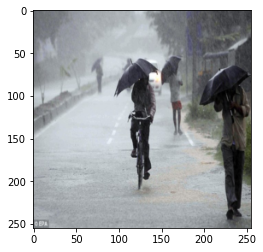

In [ ]:
#viewing the images by matplotlib

import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: ', training_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0)) #change dimension from 3,255,255 to 255,255,3 for matplotlib 

show_example(*training_dataset[700])    

In [ ]:
#splitting training dataset into train_ds and val_ds 

random_seed = 42
torch.manual_seed(random_seed);

val_size = 250
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1250, 250)

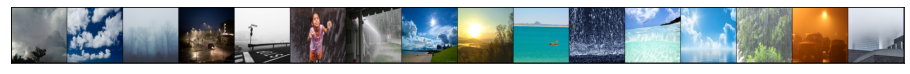

In [ ]:
#We can now create data loaders for training and validation, to load the data in batches

from torch.utils.data.dataloader import DataLoader

batch_size=16

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

#We can look at batches of images from the dataset using the `make_grid` method from `torchvision`.

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)



Let's define the model by extending an `ImageClassificationBase` class which contains helper methods for training & validation.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

Training the Model

In [ ]:
@torch.no_grad() 
def evaluate(model, val_loader):
    model.eval() 
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() 

        train_losses = [] 

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item() 
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return training_dataset.classes[preds[0].item()]

##Resnet9

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)] 
    
    if pool: layers.append(nn.MaxPool2d(2)) 
    return nn.Sequential(*layers) 


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) 
        self.conv2 = conv_block(64, 128, pool=True) 
        
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
            
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Linear(512*15*15, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out) 
        
        out = self.res1(out) + out 
        
        out = self.conv3(out) 
        out = self.conv4(out) 
        
        out = self.res2(out) + out 
        
        out = self.classifier(out) 
        return out

In [ ]:
model_resnet = to_device(ResNet9(3, 5), device) #num_classes=5
model_resnet

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
history3 = [evaluate(model_resnet, val_dl)]
history3

[{'val_acc': 0.21424278616905212, 'val_loss': 1.6098284721374512}]

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history3 = fit(num_epochs, lr, model_resnet, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 22.9017, val_loss: 5.4826, val_acc: 0.4835
Epoch [1], train_loss: 23.2974, val_loss: 14.8484, val_acc: 0.5361
Epoch [2], train_loss: 16.3085, val_loss: 9.6904, val_acc: 0.5237
Epoch [3], train_loss: 11.0337, val_loss: 9.6389, val_acc: 0.5418
Epoch [4], train_loss: 7.1412, val_loss: 5.2728, val_acc: 0.5652
Epoch [5], train_loss: 6.2227, val_loss: 5.9451, val_acc: 0.6569
Epoch [6], train_loss: 10.8328, val_loss: 6.4633, val_acc: 0.5412
Epoch [7], train_loss: 6.0355, val_loss: 3.6401, val_acc: 0.6472
Epoch [8], train_loss: 4.0667, val_loss: 2.3634, val_acc: 0.6629
Epoch [9], train_loss: 4.7266, val_loss: 2.3128, val_acc: 0.6842
Epoch [10], train_loss: 3.4416, val_loss: 6.9615, val_acc: 0.6052
Epoch [11], train_loss: 5.8081, val_loss: 3.7346, val_acc: 0.6638
Epoch [12], train_loss: 4.7994, val_loss: 1.7015, val_acc: 0.7058
Epoch [13], train_loss: 3.4305, val_loss: 1.6154, val_acc: 0.7094
Epoch [14], train_loss: 1.7242, val_loss: 1.2772, val_acc: 0.6842
Epoch [15], tr

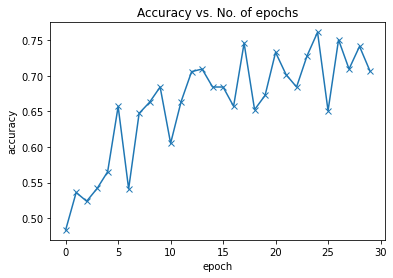

In [ ]:
plot_accuracies(history3)

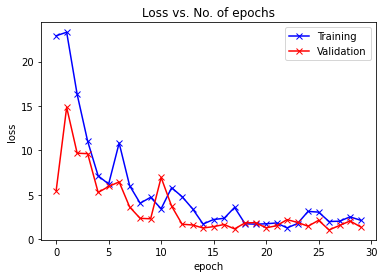

In [ ]:
plot_losses(history3)


Label: rainy , Predicted: rainy


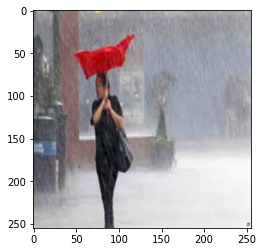

In [ ]:
img, label = testing_dataset[76]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet))


Label: shine , Predicted: shine


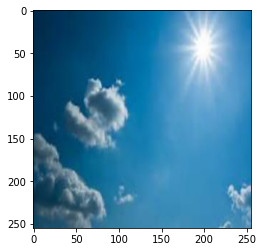

In [ ]:
img, label = testing_dataset[160]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet, test_loader)
result

{'val_acc': 0.8046875, 'val_loss': 1.5362578630447388}

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer): 
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step() 
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(model_resnet, val_dl)

{'val_acc': 0.23227164149284363, 'val_loss': 1.6082937717437744}

In [ ]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1 
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history5 = fit_one_cycle(epochs, max_lr, model_resnet, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 7.9362, val_loss: 12.0779, val_acc: 0.4757
Epoch [1], train_loss: 13.4463, val_loss: 146.3422, val_acc: 0.3510
Epoch [2], train_loss: 29.9673, val_loss: 7.7601, val_acc: 0.6920
Epoch [3], train_loss: 19.5240, val_loss: 1.6051, val_acc: 0.5904
Epoch [4], train_loss: 6.8587, val_loss: 3.1727, val_acc: 0.6460
Epoch [5], train_loss: 8.0498, val_loss: 1.4589, val_acc: 0.6073
Epoch [6], train_loss: 1.6109, val_loss: 0.8582, val_acc: 0.6833
Epoch [7], train_loss: 1.5495, val_loss: 0.8955, val_acc: 0.6743
Epoch [8], train_loss: 1.5428, val_loss: 1.2899, val_acc: 0.6821
Epoch [9], train_loss: 1.1187, val_loss: 0.6965, val_acc: 0.7163
Epoch [10], train_loss: 1.1409, val_loss: 1.3049, val_acc: 0.6502
Epoch [11], train_loss: 1.0760, val_loss: 0.7692, val_acc: 0.7212
Epoch [12], train_loss: 0.6303, val_loss: 0.6573, val_acc: 0.7512
Epoch [13], train_loss: 0.9752, val_loss: 1.0269, val_acc: 0.7290
Epoch [14], train_loss: 0.6947, val_loss: 0.8654, val_acc: 0.7269
Epoch [15], tr

In [ ]:
epochs = 5
max_lr = 0.005 
grad_clip = 0.1 
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history5 += fit_one_cycle(epochs, max_lr, model_resnet, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.0582, val_loss: 2.7930, val_acc: 0.7224
Epoch [1], train_loss: 12.9645, val_loss: 1.6133, val_acc: 0.5679
Epoch [2], train_loss: 3.3580, val_loss: 0.7934, val_acc: 0.7251
Epoch [3], train_loss: 1.4197, val_loss: 0.8684, val_acc: 0.7524
Epoch [4], train_loss: 1.3926, val_loss: 0.8335, val_acc: 0.7437


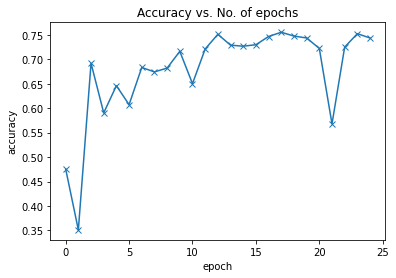

In [ ]:
plot_accuracies(history5)

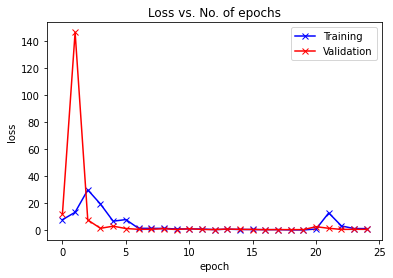

In [ ]:
plot_losses(history5)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

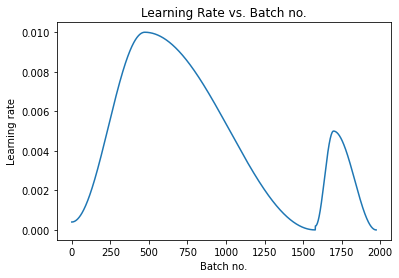

In [ ]:
plot_lrs(history5)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet, test_loader)
result

{'val_acc': 0.859375, 'val_loss': 0.37874966859817505}

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet9.pth" 
torch.save(model_resnet.state_dict(), path)

##Resnet 34

In [ ]:
import torchvision.models as models

class Resnet34CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
         
    def forward(self, xb):
        xb= self.network(xb)
        return xb    
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False 
        for param in self.network.fc.parameters():
            param.require_grad = True 
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [ ]:
model_resnet34 = to_device(Resnet34CnnModel(), device)
model_resnet34

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Resnet34CnnModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
evaluate(model_resnet34, val_dl)

{'val_acc': 0.11808894574642181, 'val_loss': 1.753415584564209}

In [ ]:
model_resnet34.freeze()

epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history6 = fit_one_cycle(epochs, max_lr, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 0.8397, val_loss: 21.7328, val_acc: 0.3014
Epoch [1], train_loss: 1.0770, val_loss: 1.9056, val_acc: 0.5210
Epoch [2], train_loss: 0.8946, val_loss: 5.2195, val_acc: 0.3254
Epoch [3], train_loss: 0.7953, val_loss: 1.7302, val_acc: 0.5361
Epoch [4], train_loss: 0.6400, val_loss: 0.4296, val_acc: 0.8519
Epoch [5], train_loss: 0.4810, val_loss: 0.2931, val_acc: 0.8966
Epoch [6], train_loss: 0.4354, val_loss: 0.2794, val_acc: 0.9005
Epoch [7], train_loss: 0.3815, val_loss: 0.2312, val_acc: 0.9075


In [ ]:
model_resnet34.unfreeze()

epochs=8
history6 += fit_one_cycle(epochs, 0.001, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 0.3566, val_loss: 0.2863, val_acc: 0.9014
Epoch [1], train_loss: 0.4035, val_loss: 0.2753, val_acc: 0.9044
Epoch [2], train_loss: 0.3795, val_loss: 0.2403, val_acc: 0.8936
Epoch [3], train_loss: 0.3960, val_loss: 0.3970, val_acc: 0.8723
Epoch [4], train_loss: 0.3533, val_loss: 0.2700, val_acc: 0.9132
Epoch [5], train_loss: 0.2970, val_loss: 0.1962, val_acc: 0.9297
Epoch [6], train_loss: 0.2510, val_loss: 0.1779, val_acc: 0.9288
Epoch [7], train_loss: 0.2311, val_loss: 0.1968, val_acc: 0.9084


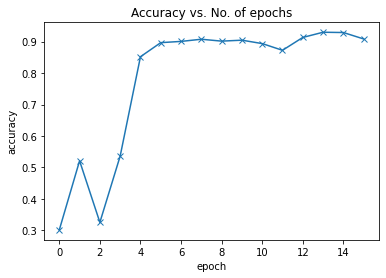

In [ ]:
plot_accuracies(history6)

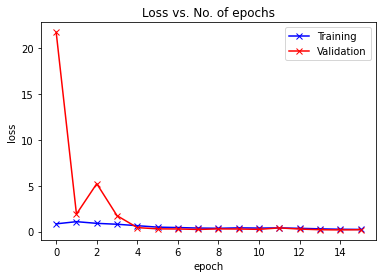

In [ ]:
plot_losses(history6)

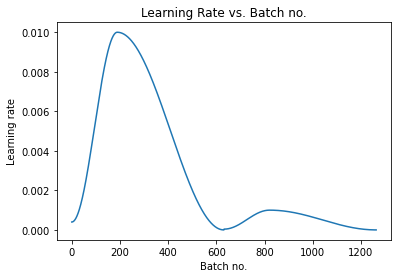

In [ ]:
plot_lrs(history6)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet34, test_loader)
result

{'val_acc': 0.96875, 'val_loss': 0.11575672030448914}

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet34.pth" 
torch.save(model_resnet34.state_dict(), path) 

In [ ]:
model_resnet34 = to_device(Resnet34CnnModel(), device)
model_resnet34.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/modelweatherusingresnet34.pth"))

<All keys matched successfully>

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
evaluate(model_resnet34, test_loader)

{'val_acc': 0.96484375, 'val_loss': 0.1168505921959877}

Label: rainy , Predicted: rainy


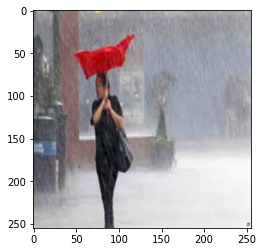

In [ ]:
img, label = testing_dataset[76]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet34))

Label: shine , Predicted: shine


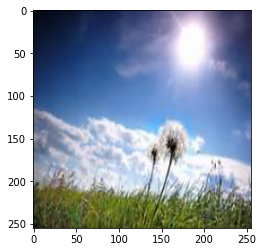

In [ ]:
img, label = testing_dataset[125]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet34))